In [2]:
import numpy as np
import pandas as pd
import cPickle as cpkl
np.random.seed(42)
import scipy.stats as sps

In [3]:
import matplotlib as mpl
# print(mpl.rcParams.items)
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
# mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline
# print(mpl.rcParams.items)

import pylab
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
import proclam
from proclam import *

In [5]:
M_classes = 13
flat_factor = 1. / M_classes

In [6]:
N_objects = 100000
generator = proclam.simulators.LogUnbalanced()
minitruth = generator.simulate(M_classes, N_objects)
pops = np.histogram(minitruth, bins=range(M_classes+1))[0]
# print(pops)
minipops = np.empty(M_classes)
for m in range(M_classes):
    minipops[m] = np.log10(np.max((pops[m], 1.))) /np.log10(N_objects)# / M_classes
# print(np.log10(minipops) / np.log10(N_objects))
# print(np.sum(minipops) / M_classes)

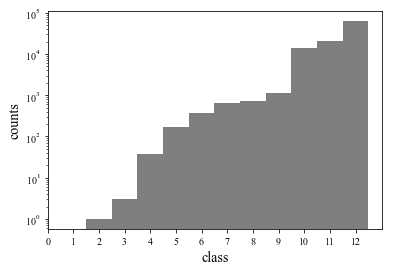

In [7]:
truth = minitruth
d = np.diff(np.unique(truth)).min()
left_of_first_bin = truth.min() - float(d)/2
right_of_last_bin = truth.max() + float(d)/2
plt.hist(truth, np.arange(left_of_first_bin, right_of_last_bin + d, d), log=True, alpha=0.5, color='k')
plt.xticks(range(max(truth)+1))
# plt.hist(truth, log=True, alpha=0.5)
plt.ylabel('counts')
plt.xlabel('class')
plt.savefig('fig/complete_counts.png')
plt.show()
plt.close()

(array([945.,  33.,   9.,   3.,   2.,   2.,   2.,   1.,   1.,   2.]),
 array([2.99639128e-06, 1.51316777e-01, 3.02630557e-01, 4.53944337e-01,
        6.05258117e-01, 7.56571897e-01, 9.07885677e-01, 1.05919946e+00,
        1.21051324e+00, 1.36182702e+00, 1.51314080e+00]),
 <a list of 10 Patch objects>)

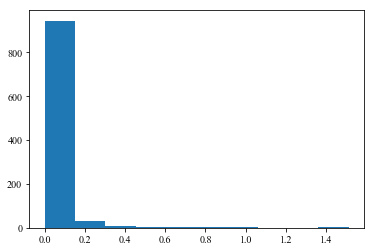

In [48]:
plt.plot(sps.halfcauchy(0., 0.01).rvs(1000))

In [8]:
def make_cm(start_cm, m, systematic, accomplice=-1):
    cm = start_cm
    big_M = len(start_cm)
    if m < 0 or m > big_M:
#         print(m)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        return cm
    if systematic == 'uncertain':
        cm[m] = np.ones(big_M)
    if systematic == 'almost':
        cm[m] = flat_factor * 0.5 * np.ones(big_M)
#         cm[:, m] = flat_factor * 0.5 * np.ones(big_M).T
        cm[m][m] += 1.5 * flat_factor
    if systematic == 'noisy':
        cm[m] = flat_factor * 0.5 * np.ones(big_M)
#         cm[:, m] = flat_factor * 0.5 * np.ones(big_M).T
        cm[m][m] += 0.5 * flat_factor
    if systematic == 'tunnel':
        cm[m] = flat_factor * np.zeros(big_M)
#         cm[:, m] = flat_factor * np.zeros(big_M).T
        cm[m][m] += 1. * flat_factor
    if systematic == 'perfect':
        cm[m] = flat_factor * np.zeros(big_M)
        cm[:, m] = flat_factor * np.zeros(big_M).T
        cm[m][m] += 1. * flat_factor
    if systematic == 'subsumed':
        cm[m] = cm[accomplice]
#     if systematic == 'cruise' or systematic == 'subsumer':
#         cm[m] = np.zeros_like(big_M)
#         cm[m, accomplice] = 1.
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    return cm

In [9]:
classifier = proclam.classifiers.FromCM()

mega_test = {}
N_affected = range(M_classes)

minidelta = 0.1

metric_info = {'LogLoss': mpl.cm.winter_r(1.), 'Brier': mpl.cm.winter_r(0.)}
which_metrics = metric_info.keys()
met_evals = {}
for met in which_metrics:
    met_evals[met] = getattr(proclam.metrics, met)()
    
all_shapes = {'uncertain':'s', 'tunnel':'o', 'almost':'P', 'noisy':'X', 'subsumed': 'D', 'perfect': '*'}

In [12]:
def cm_mega_plot(info_dict, systematics, m, fn='', numrows=2, numcols=4):
    fig = pylab.figure(figsize=(5.1, 5.1))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_title(fn+' with '+str(m)+' affected')
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(numrows,numcols),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.01,
                 )
    gridnos = np.arange(numrows * numcols).reshape((numcols, numrows)).T.flatten()
    for j in range(numcols * numrows):
        i = gridnos[j]
        ax = grid[j]#fig.add_subplot(numrows,numcols,i+1)#, frameon=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        position = ax.get_position()
#         print(position)
        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
#         print(position)
        testname = systematics[j]
        
        im = ax.imshow(info_dict[testname]['cm'][m], vmin=0., vmax=1., cmap='winter_r')
        ax.text(.5,.9,testname,horizontalalignment='center',transform=ax.transAxes, fontsize=16)
#     pylab.colorbar()
#     fig.subplots_adjust(right=0.5)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    bigAxes.set_ylabel(r'true class', fontsize=20)
    bigAxes.set_xlabel(r'predicted class', fontsize=20)
    pylab.tight_layout()
    pylab.savefig('fig/systest_'+fn+'_cm.png', bbox_inches='tight', pad_inches=0)

In [ ]:
# cm_mega_plot(mega_test['uncertain'], which_systematics, m=4, fn='all_cm', numrows=2, numcols=4)

# test number affected by each systematic relative to different baselines

In [11]:
# and make another version for varying weights!

def one_loop_naff(collector, name, which_systematics, starter):# mega_test, 'reltoagnostic'
    systest = {}
#     systematic_info = all_shapes[which_systematics]
    w = 'per_class'
    for s in which_systematics:
        systest[s] = {}
        for met in which_metrics:
            systest[s][met] = np.empty(M_classes+1)
        m = -1
        temp_cm = starter
        systest[s]['cm'] = np.empty((M_classes+1, M_classes, M_classes))
        systest[s]['probs'] = np.empty((M_classes+1, N_objects, M_classes))
        while m < M_classes:
            temp_cm = make_cm(temp_cm, m, s)
#             try:
#                 assert(np.all(np.isclose(np.sum(temp_cm, axis=1)[:, np.newaxis], np.ones(M_classes))))
#             except AssertionError:
#                 print(temp_cm)
            probs = classifier.classify(temp_cm, minitruth, delta=minidelta, other=False)
            if m < 0:
                print(np.sum(np.argmax(probs, axis=1) == minitruth)/float(N_objects))
            m += 1
            systest[s]['cm'][m] = temp_cm
            systest[s]['probs'][m] = probs
            for met in which_metrics:
                D = met_evals[met]
                metval = D.evaluate(probs, minitruth, averaging=w)
                systest[s][met][m] = metval
#         print(s+' on '+name)
    collector[name] = systest
    return collector

## isolating the systematics with flat weights, relative to uncertain

In [ ]:
which_systematics = ['tunnel', 'almost', 'noisy', 'subsumed']
starter = np.ones((M_classes, M_classes))
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
mega_test = one_loop_naff(mega_test, 'uncertain', which_systematics, starter)

In [ ]:
# cm_mega_plot(mega_test['uncertain'], which_systematics, m=4, fn='uncertain', numrows=2, numcols=2)

## isolating the systematics with flat weights, relative to perfect

In [ ]:
which_systematics = ['almost', 'noisy', 'uncertain', 'subsumed']
starter = np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
mega_test = one_loop_naff(mega_test, 'perfect', which_systematics, starter)

In [ ]:
# cm_mega_plot(mega_test['perfect'], which_systematics, m=4, fn='perfect', numrows=2, numcols=2)

## isolating the systematics with flat weights, relative to almost perfect

In [ ]:
which_systematics = ['tunnel', 'noisy', 'uncertain', 'subsumed']
starter = 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
mega_test = one_loop_naff(mega_test, 'almost', which_systematics, starter)

In [ ]:
# cm_mega_plot(mega_test['almost'], which_systematics, m=4, fn='almost', numrows=2, numcols=2)

## isolating the systematics with flat weights, relative to noisy

In [ ]:
which_systematics = ['tunnel', 'almost', 'uncertain', 'subsumed']
starter = 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]
mega_test = one_loop_naff(mega_test, 'noisy', which_systematics, starter)

In [ ]:
# cm_mega_plot(mega_test['noisy'], which_systematics, m=4, fn='noisy', numrows=2, numcols=2)

## summary plots

In [13]:
# connect lines along systematic, weighting, and affected class
def sys_only_plot(dataset, metric_info, shapes, fn=''):
    
    systematics = dataset.keys()
    fig = pylab.figure(figsize=(10.2, 10.))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxesP = bigAxes.twinx()
    bigAxesP.set_yticks([])
    bigAxes.set_ylabel(metric_info.keys()[0], fontsize=20, labelpad=25, color=metric_info.values()[0])
    bigAxes.set_xlabel(r'number of classes affected', fontsize=20, labelpad=25)
    bigAxesP.set_ylabel(metric_info.keys()[1], rotation=270, fontsize=20, 
                        labelpad=50, color=metric_info.values()[1])
    bigAxes.set_title(fn+' plus systematics')
    for si in range(len(systematics)):
        s = systematics[si]
        ax = fig.add_subplot(221+si)
        axp = ax.twinx()
        ax.set_xticks([0, 4, 8, 12])
        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        axp.set_yticks([0.02, 0.04, 0.06, 0.08, 0.1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        axp.set_yticklabels([])
        if si > 1:
            ax.set_xticklabels([0, 4, 8, 12])
        if si%2 == 1:
            axp.set_yticklabels([0.02, 0.04, 0.06, 0.08, 0.1])
        else: 
            ax.set_yticklabels([0.5, 1.5, 2.5, 3.5])
            
        position = ax.get_position()

        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)

        ax.text(.5, .9, s, 
                horizontalalignment='center',
                transform=ax.transAxes, fontsize=20)
        ax.plot(np.arange(M_classes+1)-0.1, dataset[s][metric_info.keys()[0]],
                  marker=shapes[s],
                  alpha=0.5, c=metric_info.values()[0])
        axp.plot(np.arange(M_classes+1)+0.1, dataset[s][metric_info.keys()[1]],
                  marker=shapes[s],
                  alpha=0.5, c=metric_info.values()[1])
        ax.set_ylim(-0.05, 3.55)
        axp.set_ylim(-0.001, 0.101)
        ax.set_xlim(-0.5, 13.5)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    pylab.savefig('fig/systematics_only'+fn+'.png', dpi=250)
    pylab.show()
    return

In [ ]:
sys_only_plot(mega_test['uncertain'], metric_info, all_shapes, fn='uncertain')
sys_only_plot(mega_test['perfect'], metric_info, all_shapes, fn='perfect')
sys_only_plot(mega_test['almost'], metric_info, all_shapes, fn='almost')
sys_only_plot(mega_test['noisy'], metric_info, all_shapes, fn='noisy')

# same thing, but as a function of the weight on that class rather than number of classes affected

note, specifying class 6 because of weird behavior when there are no true class members

In [14]:
relwttest = {}
abswttest = {}
only_weight = 0

weight_choices = {}
big_W = {}

weight_choices['rel'] = np.arange(0., 2.25, 0.25)
big_W['rel'] = len(weight_choices['rel'])

weight_choices['abs'] = np.arange(0., 1.1, 0.1)
big_W['abs'] = len(weight_choices['abs'])

wts = {}
wts['rel'] = np.ones((big_W['rel'], M_classes))
for wi in range(big_W['rel']):
    wts['rel'][wi][only_weight] = weight_choices['rel'][wi]
wts['rel'] = wts['rel'] / np.sum(wts['rel'], axis=1)[:, np.newaxis]

wts['abs'] = np.empty((big_W['abs'], M_classes))
for wi in range(big_W['abs']):
    wts['abs'][wi] = (1. - weight_choices['abs'][wi]) / (M_classes - 1.) * np.ones(M_classes)
    wts['abs'][wi][only_weight] = weight_choices['abs'][wi]
wts['abs'] = wts['abs'] / np.sum(wts['abs'], axis=1)[:, np.newaxis]

which_baselines = {'uncertain': np.ones((M_classes, M_classes)), 
                   'perfect': np.eye(M_classes), 
                   'almost': 0.5 * np.ones((M_classes, M_classes)) + 1.5 * np.eye(M_classes), 
                   'noisy': 0.5 * np.ones((M_classes, M_classes)) + 0.5 * np.eye(M_classes)}

In [15]:
def one_loop_wt(collector, name, which_systematics, style='rel'):# mega_test, 'reltoagnostic'
    systest = {}
    starter = which_systematics[name]
    cm = make_cm(starter, only_weight, 'tunnel')
    probs = classifier.classify(cm, minitruth, other=False)
    systest['cm'] = starter
    systest['probs'] = probs
    for met in which_metrics:
        systest[met] = []
    for wi in range(big_W[style]):
        w = weight_choices[style][wi]
#         systest['weights'].append(wts[wi])
        for met in which_metrics:
            D = met_evals[met]
            metval = D.evaluate(probs, minitruth, averaging=wts[style][wi])
            systest[met].append(metval)
#                 print(s+' on '+name+' with '+str(m)+': '+met+' = '+str(metval))
    collector[name] = systest
    return collector

In [ ]:
abswttest = one_loop_wt(abswttest, 'uncertain', which_baselines, style='abs')
abswttest = one_loop_wt(abswttest, 'perfect', which_baselines, style='abs')
abswttest = one_loop_wt(abswttest, 'almost', which_baselines, style='abs')
abswttest = one_loop_wt(abswttest, 'noisy', which_baselines, style='abs')

In [ ]:
relwttest = one_loop_wt(relwttest, 'uncertain', which_baselines, style='rel')
relwttest = one_loop_wt(relwttest, 'perfect', which_baselines, style='rel')
relwttest = one_loop_wt(relwttest, 'almost', which_baselines, style='rel')
relwttest = one_loop_wt(relwttest, 'noisy', which_baselines, style='rel')

In [16]:
# connect lines along systematic, weighting, and affected class
def wt_only_plot(dataset, metric_info, shapes, style='rel'):
    baselines = dataset.keys()
    fig = pylab.figure(figsize=(10.2, 10.))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxesP = bigAxes.twinx()
    bigAxesP.set_yticks([])
    bigAxes.set_ylabel(metric_info.keys()[0], fontsize=20, labelpad=25, color=metric_info.values()[0])
    bigAxes.set_xlabel(style+r'. weight on class', fontsize=20, labelpad=25)
    bigAxesP.set_ylabel(metric_info.keys()[1], rotation=270, fontsize=20, 
                        labelpad=50, color=metric_info.values()[1])
    bigAxes.set_title('tunnel on baselines')
    for si in range(len(baselines)):
        s = baselines[si]
        ax = fig.add_subplot(221+si)
        axp = ax.twinx()
        ax.set_xticks(wts[style].T[0])
        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        axp.set_yticks([0.02, 0.04, 0.06, 0.08, 0.1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        axp.set_yticklabels([])
        if si > 1:
            wt_labels = [str(w)[:3] for w in weight_choices[style]]
            ax.set_xticklabels(wt_labels)
        if si%2 == 1:
            axp.set_yticklabels([0.02, 0.04, 0.06, 0.08, 0.1])
        else: 
            ax.set_yticklabels([0.5, 1.5, 2.5, 3.5])
            
        position = ax.get_position()

        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
        
        ax.text(.5, .9, s, 
                horizontalalignment='center',
                transform=ax.transAxes, fontsize=20)
        ax.plot(wts[style].T[0], dataset[s][metric_info.keys()[0]],
                  marker=shapes[s],
                  alpha=0.5, c=metric_info.values()[0])
        axp.plot(wts[style].T[0], dataset[s][metric_info.keys()[1]],
                  marker=shapes[s],
                  alpha=0.5, c=metric_info.values()[1])
        ax.set_ylim(-0.05, 2.75)
        axp.set_ylim(-0.001, 0.081)
#         ax.set_xlim(-0.25, 2.25)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    pylab.savefig('fig/tunnel_'+style+'_weights_on_baselines.png', dpi=250)
    pylab.show()
    return

In [ ]:
wt_only_plot(abswttest, metric_info, all_shapes, style='abs')

In [ ]:
wt_only_plot(relwttest, metric_info, all_shapes, style='rel')

# probably not using below here

In [17]:
def make_wv(m, wt_kw):
#     wv = np.ones(M_classes)
    if wt_kw == 'by pop':
        wv = minipops
    if wt_kw == 'flat': 
        wv = np.ones(M_classes)
    if wt_kw == 'up':
        wv = np.ones(M_classes)
        wv[m] += 1.
    if wt_kw == 'down':
        wv = np.ones(M_classes)
        wv[m] /= 2.
    wv = wv / np.sum(wv)
    assert(np.isclose(np.sum(wv), 1.))
    return wv

In [ ]:
which_weighted = ['by pop', 'flat', 'up', 'down']
wt_colors = [mpl.cm.winter_r(minipops), [mpl.cm.autumn_r(0.5)]*M_classes, [mpl.cm.autumn_r(1.)]*M_classes, [mpl.cm.autumn_r(0.)]*M_classes]
wt_const = 1. / float(M_classes)
    
which_metrics = ['Brier', 'LogLoss']

In [ ]:
miniweights = np.empty((len(which_weighted), M_classes, M_classes))
for m in which_affected:
    for wi in range(len(which_weighted)):
        w = which_weighted[wi]
        miniweights[wi][m] = make_wv(m, w)

In [ ]:
# warning: slow!!!
for s in which_systematics:
    minitest[s] = {}
    for m in which_affected:
        minitest[s][str(m)] = {}
        minitest[s][str(m)]['cm'] = make_cm(starter, m, s)
        minitest[s][str(m)]['probs'] = classifier.classify(minitest[s][str(m)]['cm'], minitruth, 
                                                           delta=minidelta, other=False)
        minitest[s][str(m)]['results'] = {}
        for met in which_metrics:
            minitest[s][str(m)][met] = {}
            for wi in range(len(which_weighted)):
                w = which_weighted[wi]
                D = getattr(proclam.metrics, met)()
                minitest[s][str(m)][met][w] = D.evaluate(minitest[s][str(m)]['probs'], minitruth, 
                                                         averaging=miniweights[wi][m])
    print('finished '+s)
    cpkl.dump(minitest[s], open(s+'_data.pkl', 'wb'))
    print('saved '+s)

In [ ]:
for s in which_systematics:
    wttest[s] = {}
    for met in which_metrics:
        wttest[s][met] = np.empty(np.shape(weight_choices))
    temp_cm = make_cm(np.eye(M_classes), 6, s)
    wttest[s]['cm'] = temp_cm
#     print(wttest[s]['cm'])
    probs = classifier.classify(wttest[s]['cm'], minitruth, other=False)
    wttest[s]['probs'] = probs# systest[s]['probs'][1]
    for wi in range(len(weight_choices)):
        w = wts[wi]
        for met in which_metrics:
            D = met_evals[met]
            metval = D.evaluate(wttest[s]['probs'], minitruth, averaging=w)
            wttest[s][met][wi] = metval
    print(s)

In [ ]:
def cm_mega_plot(info_dict, systematics, m, fn='', numrows=2, numcols=4):
    fig = pylab.figure(figsize=(5.1, 5.1))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    bigAxes.set_title(fn+' with '+str(m)+' affected')
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(numrows,numcols),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.01,
                 )
    gridnos = np.arange(numrows * numcols).reshape((numcols, numrows)).T.flatten()
    for j in range(numcols * numrows):
        i = gridnos[j]
        ax = grid[j]#fig.add_subplot(numrows,numcols,i+1)#, frameon=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        position = ax.get_position()
#         print(position)
        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
#         print(position)
        testname = systematics[j]
        
        im = ax.imshow(info_dict[testname]['cm'][m], vmin=0., vmax=1., cmap='winter_r')
        ax.text(.5,.9,testname,horizontalalignment='center',transform=ax.transAxes, fontsize=16)
#     pylab.colorbar()
#     fig.subplots_adjust(right=0.5)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    bigAxes.set_ylabel(r'true class', fontsize=20)
    bigAxes.set_xlabel(r'predicted class', fontsize=20)
    pylab.tight_layout()
    pylab.savefig('fig/systest_'+fn+'_cm.png', bbox_inches='tight', pad_inches=0)

In [ ]:
# connect lines along systematic, weighting, and affected class
def wt_only_plot(dataset, metric_names, shapes):
    
    systematics = dataset.keys()
    fig = pylab.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    axp = ax.twinx()
    for si in range(len(systematics)):
        s = systematics[si]
        axp.plot(weight_choices, dataset[s][metric_names[0]], marker=markerlist[si], color='g', alpha=0.25)
        ax.plot(weight_choices, dataset[s][metric_names[1]], marker=markerlist[si], color='b', alpha=0.25)
        ax.scatter(-1., -1., c='k',
                  marker=markerlist[si],
                  alpha=0.25, label=systematics[si])
    ax.legend(loc='upper left')
    ax.set_xlabel('weight relative to unaffected classes')
    ax.set_ylabel(metric_names[1])
    axp.set_ylabel(metric_names[0])
    ax.set_xlim(-0.25, 2.25)
    ax.set_ylim(1., 1.7)
    axp.set_ylim(0.044, 0.055)
    plt.show()
#     bigAxes = pylab.axes(frameon=False)     # hide frame
#     bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
#     bigAxes.set_yticks([])
#     bigAxesP = bigAxes.twinx()
#     bigAxesP.set_yticks([])
#     bigAxes.set_ylabel(metric_names[1], fontsize=20, labelpad=25)
#     bigAxes.set_xlabel(r'weight relative to other classes', fontsize=20, labelpad=25)
#     bigAxesP.set_ylabel(metric_names[0], rotation=270, fontsize=20, 
#                         labelpad=50)

#     for si in range(len(systematics)):
#         s = systematics[si]
#         ax = fig.add_subplot(221+si)
#         axp = ax.twinx()
#         ax.set_xticks(weight_choices)
# #         axp.set_yticks([0.04, 0.05, 0.06, 0.07, 0.08])
# #         ax.set_yticks([1., 1.5, 2., 2.5, 3., 3.5])
# #         ax.set_xticklabels([])
# #         ax.set_yticklabels([])
# #         axp.set_yticklabels([])
#         if si > 1:
#             ax.set_xticklabels(weight_choices)
# #         if si%2 == 1:
# #             axp.set_yticklabels([0.04, 0.05, 0.06, 0.07, 0.08])
# #         else: 
# #             ax.set_yticklabels([1., 1.5, 2., 2.5, 3., 3.5])
            
#         position = ax.get_position()

#         position.x0 += 0.01
#         position.y0 += 0.02
#         position.x1 += 0.01
#         position.y1 += 0.02
#         ax.set_position(position)

#         ax.text(.5, .9, s, 
#                 horizontalalignment='center',
#                 transform=ax.transAxes, fontsize=20)
#         ax.plot(weight_choices, dataset[s][metric_names[1]],
#                   marker=markerlist[si],
#                   alpha=0.5, c='b')
#         axp.plot(weight_choices, dataset[s][metric_names[0]],
#                   marker=markerlist[si],
#                   alpha=0.5, c='g')
# #         ax.set_ylim(0.95, 3.55)
# #         axp.set_ylim(0.039, 0.081)
# #         ax.set_xlim(-0., 2.)
    
#     fig.tight_layout()
#     fig.subplots_adjust(hspace=0.01, wspace=0.01)
#     pylab.savefig('fig/weighting_only.png', dpi=250)
#     pylab.show()
    return

In [ ]:
wt_only_plot(wttest, which_metrics, markerlist)

## first, when the systematics are added to perfect classifier

In [18]:
classifier = proclam.classifiers.FromCM()

minitest = {}
which_affected = range(M_classes)
systematic_info = {'uncertain':'s', 'almost':'P', 'noisy':'X', 'subsumed': 'D'}#{'uncertain':'s', 'almost':'P', 'noisy':'X', 'cruise':'d', 'subsumed':(3,0,0)}
which_systematics = systematic_info.keys()#['agnostic', 'tunnel', 'almost', 'noisy', 'tunnel', 'cruise', 'subsumed']
markerlist = systematic_info.values()#['', '', 'd', 'o', 'd', 's', (3,0,0)]

minidelta = 0.1
starter = np.eye(M_classes)# + minidelta * np.ones((M_classes, M_classes))
# starter = starter / np.sum(starter, axis=1)[:, np.newaxis]

In [22]:
which_weighted = ['by pop']#['by pop', 'flat', 'up', 'down']
wt_colors = [mpl.cm.winter_r(minipops)]#[mpl.cm.winter_r(minipops), [mpl.cm.autumn_r(0.5)]*M_classes, [mpl.cm.autumn_r(1.)]*M_classes, [mpl.cm.autumn_r(0.)]*M_classes]
wt_const = 1. / float(M_classes)
    
which_metrics = ['Brier', 'LogLoss']

In [20]:
miniweights = np.empty((len(which_weighted), M_classes, M_classes))
for m in which_affected:
    for wi in range(len(which_weighted)):
        w = which_weighted[wi]
        miniweights[wi][m] = make_wv(m, w)

In [21]:
# warning: slow!!!
for s in which_systematics:
    minitest[s] = {}
    for m in which_affected:
        minitest[s][str(m)] = {}
        minitest[s][str(m)]['cm'] = make_cm(starter, m, s)
        minitest[s][str(m)]['probs'] = classifier.classify(minitest[s][str(m)]['cm'], minitruth, 
                                                           delta=minidelta, other=False)
        minitest[s][str(m)]['results'] = {}
        for met in which_metrics:
            minitest[s][str(m)][met] = {}
            for wi in range(len(which_weighted)):
                w = which_weighted[wi]
                D = getattr(proclam.metrics, met)()
                minitest[s][str(m)][met][w] = D.evaluate(minitest[s][str(m)]['probs'], minitruth, 
                                                         averaging=miniweights[wi][m])
    print('finished '+s)
    cpkl.dump(minitest[s], open('180718_'+s+'_data.pkl', 'wb'))
    print('saved '+s)

(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.04472373812073757)
(3, 3, 0.004410653980608075)
(4, 38, 0.007648085765574965)
(5, 165, 0.010558599571294685)
(6, 364, 0.014175019110897547)
(7, 653, 0.012567817750906353)
(8, 713, 0.012713965247293754)
(9, 1104, 0.012035946673811412)
(10, 14162, 0.012214042105234926)
(11, 20443, 0.012110171585450046)
(12, 62354, 0.012139614805632854)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.9998718336667812)
(3, 3, 0.2343309293509084)
(4, 38, 0.28155876848422773)
(5, 165, 0.34027120126646104)
(6, 364, 0.4042795920563534)
(7, 653, 0.37597649238313113)
(8, 713, 0.384511589961837)
(9, 1104, 0.36453499549349433)
(10, 14162, 0.37080076171419096)
(11, 20443, 0.3703542721206394)
(12, 62354, 0.3697441514263748)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.026915802790041462)
(3, 3, 0.005499691118832138)
(4, 38, 0.011755529973166628)
(5, 165, 0.014611535866521015)
(6, 364, 0.01125114698388201)
(7, 653, 0.011998356918384977)
(8, 713, 0.013745749487944237)
(9, 1104, 0.011660132809308086)
(10, 14162, 

(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 2.7164743980536543)
(3, 3, 1.5450369849336758)
(4, 38, 1.653946570096414)
(5, 165, 1.7341872948934187)
(6, 364, 1.645215899394843)
(7, 653, 1.6905466020358764)
(8, 713, 1.6937235327071034)
(9, 1104, 1.6880130324983738)
(10, 14162, 1.6834499787276038)
(11, 20443, 1.680022741172275)
(12, 62354, 0.36880192280508906)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.009161888335267024)
(3, 3, 0.05602172077795427)
(4, 38, 0.05470379634368627)
(5, 165, 0.05930992697695837)
(6, 364, 0.057949194129855754)
(7, 653, 0.05699097632140653)
(8, 713, 0.05761598943139796)
(9, 1104, 0.0579233569173342)
(10, 14162, 0.05738855781898168)
(11, 20443, 0.057387120510864045)
(12, 62354, 0.0573391852362674)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.40077595469954497)
(3, 3, 1.6684789923258494)
(4, 38, 1.6102177969128468)
(5, 165, 1.7747117394175265)
(6, 364, 1.697470536535411)
(7, 653, 1.6710775982518133)
(8, 713, 1.6984161391633419)
(9, 1104, 1.695579054730339)
(10, 14162, 1.6827492110441113)
(11, 20443,

(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.07725208042793234)
(3, 3, 0.08151745014849163)
(4, 38, 0.07778023021619418)
(5, 165, 0.07793005618735276)
(6, 364, 0.07809072600199994)
(7, 653, 0.077174760860934)
(8, 713, 0.07754417972477341)
(9, 1104, 0.07782592957848018)
(10, 14162, 0.0778307730803265)
(11, 20443, 0.07779748141196767)
(12, 62354, 0.05738791886805233)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 2.925149094243241)
(3, 3, 2.916946153497403)
(4, 38, 2.9320739957640507)
(5, 165, 2.8938457032501717)
(6, 364, 2.9008979710833045)
(7, 653, 2.867642344780272)
(8, 713, 2.88630652144656)
(9, 1104, 2.87921759156074)
(10, 14162, 2.879066217383099)
(11, 20443, 2.8803965726552514)
(12, 62354, 1.6835827912359382)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.0734883121129385)
(3, 3, 0.07804017589312465)
(4, 38, 0.08326884715555084)
(5, 165, 0.07825825313956751)
(6, 364, 0.07871055148338316)
(7, 653, 0.078337939591207)
(8, 713, 0.07824194882983537)
(9, 1104, 0.07745605079872153)
(10, 14162, 0.07768104706119483)
(11, 20443, 0.

(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.0783857237808547)
(3, 3, 0.05992314844031531)
(4, 38, 0.08001167267816797)
(5, 165, 0.07483875174198962)
(6, 364, 0.0760636954611539)
(7, 653, 0.07464861512501395)
(8, 713, 0.0755438806835844)
(9, 1104, 0.07488787431548109)
(10, 14162, 0.07479509541675282)
(11, 20443, 0.07757308519936022)
(12, 62354, 0.057215210860291854)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 3.0921250488784358)
(3, 3, 2.1392678207934837)
(4, 38, 2.882700852687546)
(5, 165, 2.690423489662839)
(6, 364, 2.7609796051175595)
(7, 653, 2.705354042394191)
(8, 713, 2.7348057240920083)
(9, 1104, 2.7101418403483337)
(10, 14162, 2.7055034819910317)
(11, 20443, 2.869101035661783)
(12, 62354, 1.6782664160014913)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.10152441923564746)
(3, 3, 0.07914719911093353)
(4, 38, 0.07527084099805582)
(5, 165, 0.07429456733996849)
(6, 364, 0.07309979727679689)
(7, 653, 0.07541452980269478)
(8, 713, 0.07506582423216303)
(9, 1104, 0.07470149990937151)
(10, 14162, 0.07471552403318837)
(11, 2

(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.06960298727899206)
(3, 3, 0.06657411545915591)
(4, 38, 0.07192117328108252)
(5, 165, 0.06752921273418262)
(6, 364, 0.06780645022623003)
(7, 653, 0.06753722185648767)
(8, 713, 0.0678995390490956)
(9, 1104, 0.06811169968743355)
(10, 14162, 0.07474972297167892)
(11, 20443, 0.07503102574818017)
(12, 62354, 0.07490182683662236)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 2.2412689494668356)
(3, 3, 2.1717225563955593)
(4, 38, 2.302631052403613)
(5, 165, 2.172715804574169)
(6, 364, 2.191629461796598)
(7, 653, 2.1711713149502345)
(8, 713, 2.1880202523349066)
(9, 1104, 2.193319271982876)
(10, 14162, 2.704764164124086)
(11, 20443, 2.7168197775193246)
(12, 62354, 2.710723494985441)
(0, 0, 0.0)
(1, 0, 0.0)
(2, 1, 0.0655528538383418)
(3, 3, 0.06923628922512402)
(4, 38, 0.06872686516205495)
(5, 165, 0.0663784121487998)
(6, 364, 0.06795082207608172)
(7, 653, 0.06802674910204443)
(8, 713, 0.06711080760631004)
(9, 1104, 0.06850958188565001)
(10, 14162, 0.06772097814793016)
(11, 2044

In [ ]:
# # warning: slow!
# goodtest = {}
# for s in which_systematics:
#     goodtest[s] = cpkl.load(open(s+'_data.pkl', 'rb'))
# #     minitest[s] = cpkl.load(open('almost_'+s+'_data.pkl', 'rb'))
#     print('loaded '+s)

In [42]:
# connect lines along systematic, weighting, and affected class
def complete_metric_plot(dataset, metric_names, shapes, fn=''):
    
    systematics = dataset.keys()
    xs = np.arange(len(systematics))
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.text(0.01, 0.8, r'size$\sim\log[N_{m}/N]$', 
            verticalalignment='center', transform=ax.transAxes, 
            fontsize=10)
    ax.text(0.01, 0.85, r'color$\sim\exp[w_{m}]$', 
            verticalalignment='center', transform=ax.transAxes, 
            fontsize=10)
    fig.subplots_adjust(right=1.)
#     handles = []
#     seeds = []
    for m in which_affected:
#         one_seed = np.log10(max(1., N_objects * float(minipops[m]))) / 10.
#         seeds.append(one_seed)
        for si in range(len(systematics)):
            s = systematics[si]
            for wi in range(len(which_weighted)):
                w = which_weighted[wi]
#                 print(miniweights[wi][m][m])
#                 rel_wt = (((miniweights[wi][m][m] - wt_const) / wt_const) + 1.) / 2.
#                 print(rel_wt)
                ax.scatter(dataset[s][str(m)][metric_names[0]][w], dataset[s][str(m)][metric_names[1]][w],
                  c=wt_colors[wi][m],
                  s=50*minipops[m] + 10.,#N_objects**miniweights[wi][m],#rel_wt,#wt_colors[wi][m],#
                  marker=markerlist[si],
                  alpha=0.25)
    for si in range(len(systematics)):
        ax.scatter(0., 0., c='k',
                  marker=markerlist[si],
                  alpha=0.25, label=systematics[si])
    
    ax.set_xlabel(metric_names[0])
    ax.set_ylabel(metric_names[1])
    ax.set_ylim(0.9, 3.5)
    ax.set_xlim(0.035, 0.09)
    ax.legend(loc='lower right')
    
#     seeds = np.array(seeds)
#     print(seeds)
    popaxins = inset_axes(ax,
                    width="25%",  # width = 25% of parent_bbox width
                    height="5%",  # height : 5%
                    loc=2)#bbox_to_anchor=(0.35, 0.8))
    mpl.colorbar.ColorbarBase(popaxins, cmap=mpl.cm.winter_r,
                                norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                              orientation='horizontal')
#     popaxins.xaxis.set_ticks_position("top")
#     popaxins.set_title(r'$w_{m}\sim N_{m}/N$', fontsize=10)
    popaxins.xaxis.set_ticks(np.concatenate((np.concatenate((np.zeros(1), np.flip(minipops, axis=0))), np.ones(1))))
    popaxins.xaxis.set_ticklabels(['0']+[]*M_classes+['1'], fontsize=10) #rotation=270, fontsize=10)
    
#     linaxins = inset_axes(ax,
#                     width="25%",  # width = 25% of parent_bbox width
#                     height="5%",  # height : 5%
#                     loc=6)#bbox_to_anchor=(0.35, 0.55))
# #     linaxins = axins.add_axes([0., 1.])
#     mpl.colorbar.ColorbarBase(linaxins, cmap=mpl.cm.autumn_r,
#                                 norm=mpl.colors.Normalize(vmin=0., vmax=1.),#vmin=0.04, vmax=0.14285714), 
#                               orientation='horizontal')
# #     linaxins.xaxis.set_ticks_position("top")
#     linaxins.set_title('flat/up/down weights', fontsize=10)
#     linaxins.xaxis.set_ticks([0., 0.5, 1.])
#     linaxins.xaxis.set_ticklabels(['downweight', 'flat', 'upweight'], 
#                                   rotation=270, fontsize=10)
    
#     plt.show()
    plt.savefig('fig/180718'+fn+'all_effects_isolated.png', dpi=250)
#     plt.close()
    return

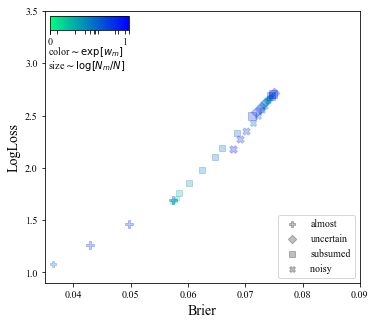

In [43]:
# complete_metric_plot(goodtest, which_metrics, markerlist, fn='almost')
complete_metric_plot(minitest, which_metrics, markerlist, fn='perfect')

In [41]:
print(20 * (1.+ minipops[5]))

28.869935776855623


## when the systematics are added to agnostic classifier

In [ ]:
starter = np.ones((M_classes, M_classes))
starter = starter / np.sum(starter, axis=1)[:, np.newaxis]

In [ ]:
# # warning: slow!!!
# for s in which_systematics:
#     minitest[s] = {}
#     for m in which_affected:
#         minitest[s][str(m)] = {}
#         minitest[s][str(m)]['cm'] = make_cm(starter, m, s)
#         minitest[s][str(m)]['probs'] = classifier.classify(minitest[s][str(m)]['cm'], minitruth, 
#                                                            delta=minidelta, other=False)
#         minitest[s][str(m)]['results'] = {}
#         for met in which_metrics:
#             minitest[s][str(m)][met] = {}
#             for wi in range(len(which_weighted)):
#                 w = which_weighted[wi]
#                 D = getattr(proclam.metrics, met)()
#                 minitest[s][str(m)][met][w] = D.evaluate(minitest[s][str(m)]['probs'], minitruth, 
#                                                          averaging=miniweights[wi][m])
#     print('finished '+s)
#     cpkl.dump(minitest[s], open('agnostic_'+s+'_data.pkl', 'wb'))
#     print('saved '+s)

In [ ]:
# warning: slow!
badtest = {}
for s in which_systematics:
#     minitest[s] = cpkl.load(open(s+'_data.pkl', 'rb'))
    badtest[s] = cpkl.load(open('agnostic_'+s+'_data.pkl', 'rb'))
    print('loaded '+s)

In [ ]:
complete_metric_plot(badtest, which_metrics, markerlist, fn='agnostic')

Would like to do this many times to generate error bars

In [ ]:
# cells with a tag of "hideme" will not appear in html resulting from:
# jupyter nbconvert desc_note/main.ipynb --TagRemovePreprocessor.remove_cell_tags='["hideme"]'
# jupyter nbconvert desc_note/main.ipynb --TagRemovePreprocessor.remove_input_tags='["hidein"]'
